In [1]:
# Add project path to the PYTHONPATH

import os
import sys
import numpy as np
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), '../')).resolve().as_posix())

In [2]:
import pickle

In [3]:
from time import time

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax

## Load Test Set

Load the test dataset

In [6]:
from nlp.dataset import Dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rmohashi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
dataset = Dataset('../datasets/semeval/testset.csv')
dataset.load()
dataset.preprocess_texts()
data = dataset.cleaned_data.copy()

Time to clean up: 1.80 sec


In [8]:
x_test = data.text
y_test = data.label

In [9]:
import seaborn as sns

In [10]:
labeled_data = data.copy()
labeled_data.label = data.label.apply(lambda x: "positivo" if x == 4 else "negativo")

[Text(0, 0.5, 'Número de tweets'), Text(0.5, 0, 'Rótulo')]

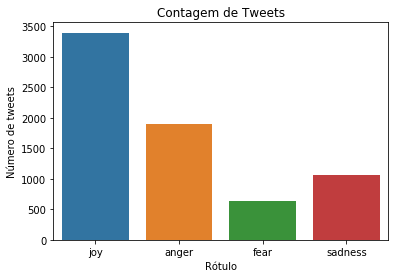

In [11]:
ax = sns.countplot(x='label', data=data)
ax.set_title('Contagem de Tweets')
ax.set(xlabel='Rótulo', ylabel='Número de tweets')

## Load Model

Load the trained naive bayes - sentiment analysis model

In [12]:
filepath = Path('../models/emotion_recognition/nb_model.pickle').resolve()
with filepath.open('rb') as file:
    model = pickle.load(file)

## Naive Bayes

In [13]:
from sklearn.metrics import classification_report

In [14]:
results = model.predict(x_test)
print(classification_report(y_test, results, digits=4))

              precision    recall  f1-score   support

       anger     0.7450    0.5761    0.6498      1892
        fear     0.4137    0.5667    0.4782       630
         joy     0.8687    0.7574    0.8092      3397
     sadness     0.4237    0.6761    0.5209      1059

    accuracy                         0.6787      6978
   macro avg     0.6128    0.6441    0.6145      6978
weighted avg     0.7265    0.6787    0.6924      6978



In [15]:
from sklearn.preprocessing import LabelBinarizer

In [16]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

Confusion matrix
[[0.57610994 0.11363636 0.09672304 0.21353066]
 [0.09365079 0.56666667 0.15555556 0.18412698]
 [0.0559317  0.05298793 0.75743303 0.13364734]
 [0.1170916  0.10481586 0.101983   0.67610954]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7dd377cc90>)

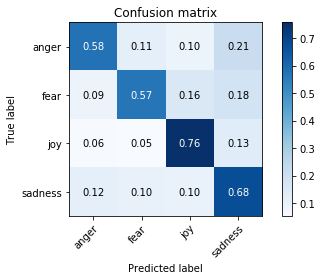

In [17]:
nb_y_test = label_binarizer.transform(y_test).argmax(axis=1)
nb_results = label_binarizer.transform(results).argmax(axis=1)
plot_confusion_matrix(nb_y_test, nb_results, label_binarizer.classes_, normalize=True)

## Neural Networks

In [19]:
import pickle
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
from emotion_recognition.models.lstm_model import lstm_model
from emotion_recognition.models.cnn_model import cnn_model
from emotion_recognition.models.lstm_conv_model import lstm_conv_model

In [21]:
tokenizer_path = Path('../datasets/emotion_recognition/tokenizer.pickle').resolve()

In [22]:
with tokenizer_path.open('rb') as file:
    tokenizer = pickle.load(file)

In [23]:
sequences = [text.split() for text in data.text]
list_tokenized = tokenizer.texts_to_sequences(sequences)

In [24]:
encoder_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/encoder.pickle').resolve()
with encoder_path.open('rb') as file:
    encoder = pickle.load(file)

In [25]:
y_test = encoder.transform(y_test).argmax(axis=1)

### 100d - GloVe

In [26]:
input_dim = len(tokenizer.word_index) + 1

In [27]:
input_length = 30
embedding_dim = 100

#### LSTM

In [28]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/LSTM_100_30_GloVe/lstm_100_30_03-0.7161.h5').resolve()

In [30]:
model = lstm_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred, digits=4))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
              precision    recall  f1-score   support

           0     0.7430    0.6432    0.6895      1892
           1     0.3739    0.7270    0.4938       630
           2     0.8663    0.7421    0.7994      3397
           3     0.5635    0.6412    0.5998      1059

    accuracy                         0.6986      6978
   macro avg     0.6367    0.6884    0.6456      6978
weighted avg     0.7425    0.6

Confusion matrix
[[0.64323467 0.15063425 0.11786469 0.08826638]
 [0.08095238 0.72698413 0.11428571 0.07777778]
 [0.06446865 0.10214895 0.7421254  0.09125699]
 [0.14258735 0.12747875 0.08876298 0.64117092]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7de5c042d0>)

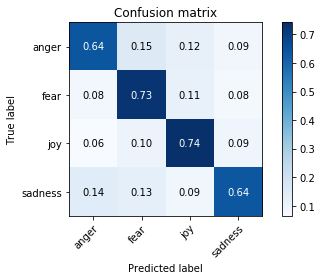

In [32]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

#### CNN

In [34]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/CNN_100_30_GloVe/cnn_100_30_03-0.7141.h5').resolve()

In [35]:
model = cnn_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7323    0.6681    0.6987      1892
           1     0.3909    0.7222    0.5072       630
           2     0.8638    0.7468    0.8011      3397
           3     0.5830    0.6336    0.6072      1059

    accuracy                         0.7061      6978
   macro avg     0.6425    0.6927    0.6536      6978
weighted avg     0.7428    0.7061    0.7174      6978



Confusion matrix
[[0.66807611 0.12790698 0.12473573 0.07928118]
 [0.1047619  0.72222222 0.12063492 0.05238095]
 [0.07006182 0.09567265 0.74683544 0.08743009]
 [0.14919736 0.13408876 0.08309726 0.63361662]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7dd4974150>)

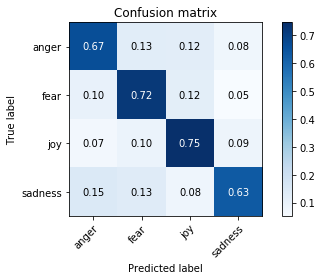

In [37]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

#### LSTM-CNN

In [38]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/LSTM_Conv_100_30_GloVe/lstm_conv_100_30_03-0.7183.h5'0.6367).resolve()

In [39]:
model = lstm_conv_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7311    0.6897    0.7098      1892
           1     0.4270    0.6968    0.5296       630
           2     0.8414    0.7919    0.8159      3397
           3     0.6374    0.5826    0.6088      1059

    accuracy                         0.7238      6978
   macro avg     0.6592    0.6903    0.6660      6978
weighted avg     0.7431    0.7238    0.7298      6978



Confusion matrix
[[0.6897463  0.10623679 0.16120507 0.04281184]
 [0.11269841 0.6968254  0.14444444 0.04603175]
 [0.06387989 0.07329997 0.79187518 0.07094495]
 [0.18130312 0.1312559  0.10481586 0.58262512]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7ddf1c9e90>)

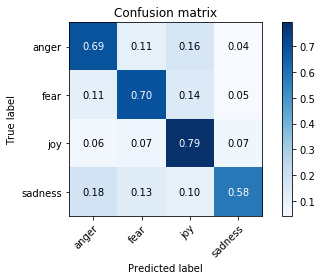

In [40]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

### 50d - no GloVe

In [41]:
input_dim = tokenizer.num_words
embedding_dim = 50

#### LSTM

In [43]:
    model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/LSTM_50_30/lstm_50_30_02-0.7029.h5').resolve()

In [44]:
model = lstm_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7699    0.5677    0.6535      1892
           1     0.4181    0.6603    0.5120       630
           2     0.8242    0.7895    0.8065      3397
           3     0.5397    0.6799    0.6018      1059

    accuracy                         0.7011      6978
   macro avg     0.6380    0.6743    0.6434      6978
weighted avg     0.7296    0.7011    0.7073      6978



Confusion matrix
[[0.56765328 0.11786469 0.17758985 0.13689218]
 [0.07619048 0.66031746 0.17619048 0.08730159]
 [0.05563733 0.06652929 0.78952016 0.08831322]
 [0.07932011 0.12275732 0.11803588 0.67988669]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7de06f2690>)

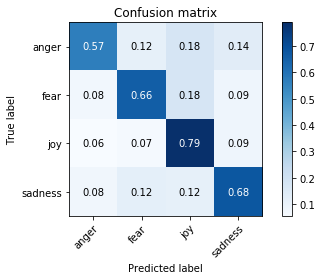

In [45]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

#### CNN

In [46]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/CNN_50_30/cnn_50_30_02-0.7050.h5').resolve()

In [47]:
model = cnn_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7462    0.6279    0.6820      1892
           1     0.4108    0.6429    0.5012       630
           2     0.8405    0.7616    0.7991      3397
           3     0.5280    0.6591    0.5863      1059

    accuracy                         0.6991      6978
   macro avg     0.6314    0.6729    0.6421      6978
weighted avg     0.7287    0.6991    0.7081      6978



Confusion matrix
[[0.62790698 0.11680761 0.14323467 0.11205074]
 [0.08253968 0.64285714 0.15714286 0.11746032]
 [0.0677068  0.07123933 0.76155431 0.09949956]
 [0.11520302 0.11142587 0.11425873 0.65911237]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7de0a3b810>)

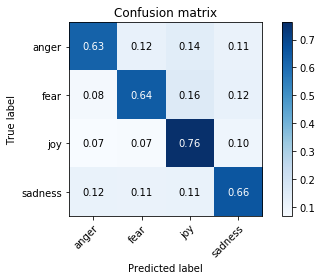

In [48]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

#### LSTM-CNN

In [49]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/LSTM_Conv_50_30/lstm_conv_50_30_02-0.7086.h5').resolve()

In [50]:
start = time()
model = lstm_conv_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 4.32 secs
              precision    recall  f1-score   support

           0     0.7739    0.5936    0.6719      1892
           1     0.4037    0.6889    0.5091       630
           2     0.8299    0.7739    0.8009      3397
           3     0.5615    0.6808    0.6155      1059

    accuracy                         0.7032      6978
   macro avg     0.6423    0.6843    0.6493      6978
weighted avg     0.7355    0.7032    0.7114      6978



Confusion matrix
[[0.5935518  0.13319239 0.16226216 0.11099366]
 [0.05873016 0.68888889 0.17619048 0.07619048]
 [0.05740359 0.07889314 0.77391816 0.0897851 ]
 [0.09065156 0.11425873 0.11425873 0.68083097]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7dd61a9e50>)

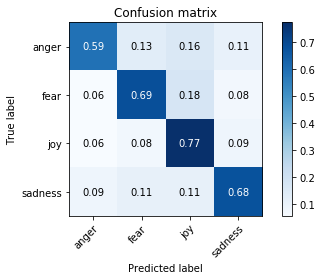

In [51]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

### 100d - no GloVe

In [52]:
embedding_dim = 100

#### LSTM

In [55]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/LSTM_100_30/lstm_100_30_02-0.7086.h5').resolve()

In [56]:
model = lstm_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7456    0.6010    0.6655      1892
           1     0.3790    0.7111    0.4945       630
           2     0.8435    0.7710    0.8056      3397
           3     0.5780    0.6364    0.6058      1059

    accuracy                         0.6991      6978
   macro avg     0.6365    0.6799    0.6429      6978
weighted avg     0.7347    0.6991    0.7092      6978



Confusion matrix
[[0.60095137 0.14852008 0.15221987 0.09830867]
 [0.08571429 0.71111111 0.13650794 0.06666667]
 [0.06211363 0.08919635 0.77097439 0.07771563]
 [0.11614731 0.14164306 0.10576015 0.63644948]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7dda6da550>)

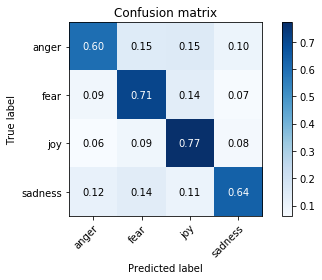

In [57]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

#### CNN

In [58]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/CNN_100_30/cnn_100_30_02-0.7069.h5').resolve()

In [59]:
start = time()
model = cnn_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 0.83 secs
              precision    recall  f1-score   support

           0     0.7692    0.5761    0.6588      1892
           1     0.4019    0.7222    0.5165       630
           2     0.8295    0.7922    0.8104      3397
           3     0.5755    0.6440    0.6078      1059

    accuracy                         0.7048      6978
   macro avg     0.6441    0.6836    0.6484      6978
weighted avg     0.7360    0.7048    0.7120      6978



Confusion matrix
[[0.57610994 0.14904863 0.17864693 0.0961945 ]
 [0.07142857 0.72222222 0.14444444 0.06190476]
 [0.05181042 0.07300559 0.79216956 0.08301442]
 [0.10009443 0.1388102  0.1170916  0.64400378]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7de07595d0>)

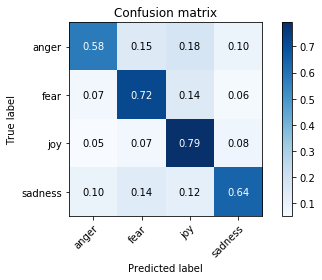

In [60]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

#### LSTM-CNN

In [61]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/LSTM_Conv_100_30/lstm_conv_100_30_02-0.7076.h5').resolve()

In [62]:
start = time()
model = lstm_conv_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 4.64 secs
              precision    recall  f1-score   support

           0     0.7497    0.6189    0.6781      1892
           1     0.4107    0.6603    0.5064       630
           2     0.8326    0.7830    0.8070      3397
           3     0.5770    0.6582    0.6149      1059

    accuracy                         0.7085      6978
   macro avg     0.6425    0.6801    0.6516      6978
weighted avg     0.7332    0.7085    0.7158      6978



Confusion matrix
[[0.61892178 0.11099366 0.17071882 0.09936575]
 [0.0968254  0.66031746 0.15714286 0.08571429]
 [0.06093612 0.0768325  0.78304386 0.07918752]
 [0.11614731 0.11898017 0.10670444 0.65816808]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7ddd160b90>)

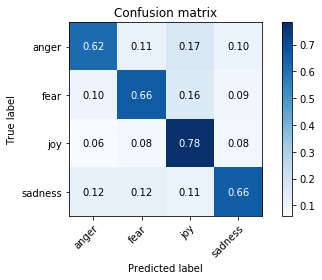

In [64]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)